# MonReader

In [ ]:
#Load Libraries
import os, sys, random, warnings
from pathlib import Path
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import tensorflow as tf
from tqdm import tqdm

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount("/content/drive")

# Directory
dir = "/content/drive/MyDrive/Personal/Apziva/images"

# Setting random state for consistency
seed = 123
np.random.seed(seed)

# Confirm GPU


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mounted at /content/drive
Fri Nov 21 15:48:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   34C    P0             59W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+---------------------

## Loading and Resizing Photos

In [ ]:
# Params
IMG_WIDTH  = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_NOT   = f"{dir}/training/notflip"
TRAIN_FLIP  = f"{dir}/training/flip"
TEST_NOT    = f"{dir}/testing/notflip"
TEST_FLIP   = f"{dir}/testing/flip"

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [ ]:
def _list_images(p):
    p = Path(p)
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff")
    files = []
    for e in exts:
        files += list(p.rglob(e))   # works whether images are directly inside or nested per-id
    return sorted(files)

def _load_and_resize(path):
    img = imread(str(path))[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True, anti_aliasing=True)
    return img.astype(np.uint8)

def load_binary_split():
    # Collect file paths and labels
    train_paths = _list_images(TRAIN_NOT)
    train_labels = [0]*len(train_paths)
    fp = _list_images(TRAIN_FLIP)
    train_paths += fp
    train_labels += [1]*len(fp)

    test_paths  = _list_images(TEST_NOT)
    test_labels = [0]*len(test_paths)
    fp = _list_images(TEST_FLIP)
    test_paths += fp
    test_labels += [1]*len(fp)

    # Shuffle deterministically
    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(train_paths))
    train_paths = [train_paths[i] for i in idx]
    train_labels = np.array([train_labels[i] for i in idx], dtype=np.int32)

    idx = rng.permutation(len(test_paths))
    test_paths = [test_paths[i] for i in idx]
    test_labels = np.array([test_labels[i] for i in idx], dtype=np.int32)

    # Load pixels
    print("Loading and resizing training images...")
    X_train = np.zeros((len(train_paths), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    for i, p in tqdm(list(enumerate(train_paths)), total=len(train_paths)):
        X_train[i] = _load_and_resize(p)

    print("Loading and resizing test images...")
    X_test = np.zeros((len(test_paths), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    for i, p in tqdm(list(enumerate(test_paths)), total=len(test_paths)):
        X_test[i] = _load_and_resize(p)

    # Scale to [0,1] floats for CNN input
    X_train = (X_train / 255.0).astype(np.float32)
    X_test  = (X_test  / 255.0).astype(np.float32)

    return X_train, train_labels, X_test, test_labels, train_paths, test_paths

X_train, y_train, X_test, y_test, train_files, test_files = load_binary_split()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


Loading and resizing training images...


100%|██████████| 2392/2392 [34:18<00:00,  1.16it/s]


Loading and resizing test images...


100%|██████████| 597/597 [12:35<00:00,  1.27s/it]


(2392, 128, 128, 3) (2392,) (597, 128, 128, 3) (597,)


## 2-D CNN Model

In [ ]:
from tensorflow.keras import layers, models

def build_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(48, 5, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(96, 5, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(96, 5, activation="relu"),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.1),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
    return m

model = build_cnn()

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 124, 124, 48)   │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 58, 58, 96)     │       115,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 29, 29, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 96)     │       230,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 96)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,985 (1.38 MB)

 Trainable params: 361,985 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Capture the model summary output
old_stdout = sys.stdout
sys.stdout = captured_summary = StringIO()
model.summary()
sys.stdout = old_stdout

# Get the summary string
summary_string = captured_summary.getvalue()

# Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 8)) # Adjust figsize as needed

# Display the summary text on the plot
ax.text(0.01, 0.99, summary_string,
        transform=ax.transAxes,
        fontsize=10,
        family='monospace',
        verticalalignment='top')

# Remove axes and borders for a cleaner look
ax.axis('off')

# Adjust layout to prevent text clipping
plt.tight_layout()

# Save the figure as a PNG
plt.savefig('model_summary.png')

# Close the plot to free up memory
plt.close(fig)

print("Model summary saved as model_summary.png")

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16,
    verbose=1
)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.5078 - auc: 0.4896 - loss: 0.6966 - val_accuracy: 0.5360 - val_auc: 0.5893 - val_loss: 0.6926
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5112 - auc: 0.5274 - loss: 0.6921 - val_accuracy: 0.5243 - val_auc: 0.6003 - val_loss: 0.6889
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5597 - auc: 0.5982 - loss: 0.6780 - val_accuracy: 0.5544 - val_auc: 0.6124 - val_loss: 0.6637
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6091 - auc: 0.6284 - loss: 0.6520 - val_accuracy: 0.6080 - val_auc: 0.6308 - val_loss: 0.6534
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6335 - auc: 0.6303 - loss: 0.6446 - val_accuracy: 0.6064 - val_auc: 0.6313 - val_loss: 0.6507
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6068 - auc: 0.6289 - loss: 0.6487 - val_accuracy: 0.5444 - val_auc: 0.6290 - val_loss: 0.6794
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━

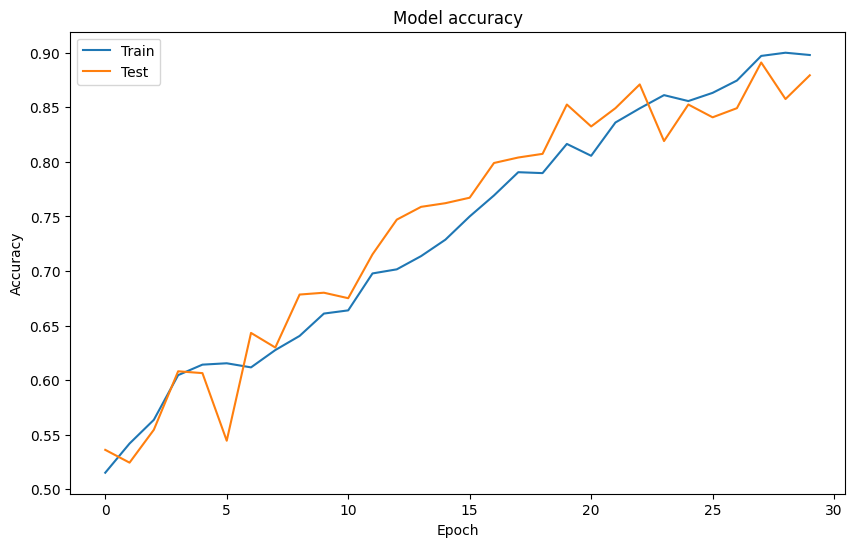

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<Figure size 800x600 with 0 Axes>

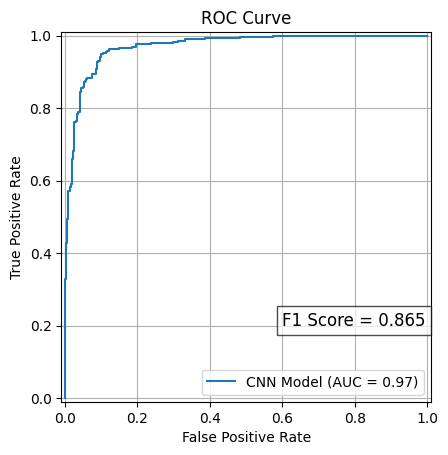

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, f1_score
import matplotlib.pyplot as plt

# Get predictions on the test set
y_pred_keras = model.predict(X_test).ravel()

# ROC
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

# Compute F1 at threshold 0.5
y_pred_binary = (y_pred_keras >= 0.5).astype(int)
f1 = f1_score(y_test, y_pred_binary)

# Plot
plt.figure(figsize=(8, 6))
RocCurveDisplay(
    fpr=fpr_keras,
    tpr=tpr_keras,
    roc_auc=auc_keras,
    estimator_name='CNN Model'
).plot()

# Add F1 annotation
plt.text(
    0.6, 0.2,                    # x, y position inside the plot
    f"F1 Score = {f1:.3f}",
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.7)
)

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()